In [1]:
#Import all the packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision

import numpy as np
import torch.nn.functional as F # useful stateless functions
import time

In [2]:
import matplotlib.pyplot as plt

In [26]:
# Load the CIFAR10 dataset

NUM_TRAIN = 49000

# transform for validation and test sets
transform = T.Compose([
                T.ToTensor(),
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
# A bit of data augmentation for the train dataset
# Turned off normalization because it seems to work better without it
transform_aug = T.Compose([
                #T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform_aug)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tensor(0.5098)
tensor(0.9216)


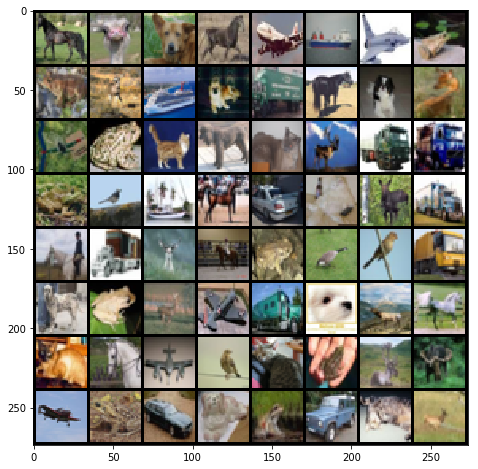

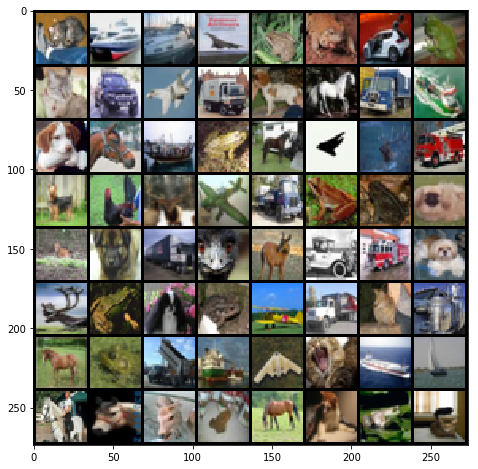

In [4]:
# Let's see what some of the images look like
def show_batch(batch):
    grid = torchvision.utils.make_grid(batch, nrow = 8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.numpy().transpose(1,2,0))
    
for x, y in loader_train:
    print(x[1,1,1,1])
    show_batch(x)
    break
    
for x, y in loader_test:
    print(x[1,1,1,1])
    show_batch(x)
    break

In [5]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


using device: cuda
Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [6]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [7]:
%matplotlib inline

In [24]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    best_acc = -1
    #scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.80, last_epoch=-1)
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(1, epochs+1):
        acc_hist = []
        loss_history = []
        t_history = []
        print('Start of epoch: ', e)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc_hist.append(check_accuracy_part34(loader_val, model))
                t_history.append(t)
                print()
        # Check accuracy at end of each epoch
        print('Accuracy after epoch ', e)
        acc = check_accuracy_part34(loader_val, model)
        
        # plot accuracy for each epoch
        acc_hist.append(acc)
        t_history.append(t)
        plt.plot(t_history, acc_hist, 'o-')
        plt.show()
        
        # save the model if acc > best_acc
        if acc > best_acc:
            saved_at_epoch = e
            best_acc = acc
            torch.save(model.state_dict(), 'checkpoint_save_state_dict')
        
        for param_group in optimizer.param_groups:
             print(param_group['lr'])
             break
        # stop lr_decay after 20th epoch
        #if e <= 12:
            #scheduler.step()
        for param_group in optimizer.param_groups:
            if e > 20:
                param_group['lr'] = 5e-4
            elif e > 50:
                param_group['lr'] = 1e-4
            elif e > 80:
                param_group['lr'] = 5e-5
            else:
                pass
        if e == epochs:
            print('Model saved at epoch: ', saved_at_epoch)

Start of epoch:  1
Iteration 0, loss = 2.5227
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)

Iteration 100, loss = 1.7841
Checking accuracy on validation set
Got 386 / 1000 correct (38.60)

Iteration 200, loss = 1.5407
Checking accuracy on validation set
Got 482 / 1000 correct (48.20)

Iteration 300, loss = 1.4170
Checking accuracy on validation set
Got 476 / 1000 correct (47.60)

Iteration 400, loss = 1.2937
Checking accuracy on validation set
Got 517 / 1000 correct (51.70)

Iteration 500, loss = 1.4122
Checking accuracy on validation set
Got 535 / 1000 correct (53.50)

Iteration 600, loss = 1.1319
Checking accuracy on validation set
Got 558 / 1000 correct (55.80)

Iteration 700, loss = 1.0926
Checking accuracy on validation set
Got 598 / 1000 correct (59.80)

Accuracy after epoch  1
Checking accuracy on validation set
Got 627 / 1000 correct (62.70)


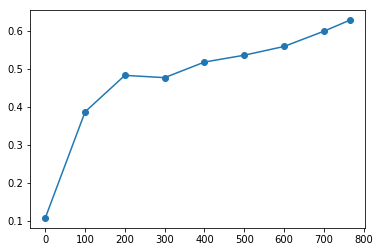

0.001
Start of epoch:  2
Iteration 0, loss = 1.0697
Checking accuracy on validation set
Got 616 / 1000 correct (61.60)

Iteration 100, loss = 1.1045
Checking accuracy on validation set
Got 615 / 1000 correct (61.50)

Iteration 200, loss = 0.9939
Checking accuracy on validation set
Got 626 / 1000 correct (62.60)

Iteration 300, loss = 1.2400
Checking accuracy on validation set
Got 603 / 1000 correct (60.30)

Iteration 400, loss = 1.1704
Checking accuracy on validation set
Got 634 / 1000 correct (63.40)

Iteration 500, loss = 0.9859
Checking accuracy on validation set
Got 690 / 1000 correct (69.00)

Iteration 600, loss = 0.9391
Checking accuracy on validation set
Got 680 / 1000 correct (68.00)

Iteration 700, loss = 0.9022
Checking accuracy on validation set
Got 710 / 1000 correct (71.00)

Accuracy after epoch  2
Checking accuracy on validation set
Got 698 / 1000 correct (69.80)


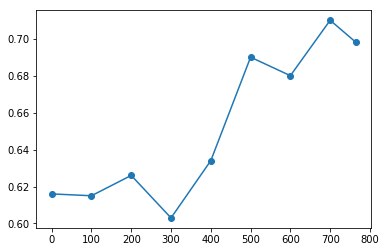

0.001
Start of epoch:  3
Iteration 0, loss = 0.8852
Checking accuracy on validation set
Got 700 / 1000 correct (70.00)

Iteration 100, loss = 0.9256
Checking accuracy on validation set
Got 707 / 1000 correct (70.70)

Iteration 200, loss = 0.9659
Checking accuracy on validation set
Got 733 / 1000 correct (73.30)

Iteration 300, loss = 1.2460
Checking accuracy on validation set
Got 721 / 1000 correct (72.10)

Iteration 400, loss = 0.7554
Checking accuracy on validation set
Got 730 / 1000 correct (73.00)

Iteration 500, loss = 0.9497
Checking accuracy on validation set
Got 731 / 1000 correct (73.10)

Iteration 600, loss = 0.5984
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)

Iteration 700, loss = 0.8137
Checking accuracy on validation set
Got 743 / 1000 correct (74.30)

Accuracy after epoch  3
Checking accuracy on validation set
Got 747 / 1000 correct (74.70)


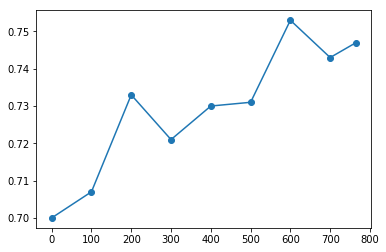

0.001
Start of epoch:  4
Iteration 0, loss = 0.8531
Checking accuracy on validation set
Got 721 / 1000 correct (72.10)

Iteration 100, loss = 0.8584
Checking accuracy on validation set
Got 727 / 1000 correct (72.70)

Iteration 200, loss = 0.9322
Checking accuracy on validation set
Got 751 / 1000 correct (75.10)

Iteration 300, loss = 0.6584
Checking accuracy on validation set
Got 701 / 1000 correct (70.10)

Iteration 400, loss = 0.7728
Checking accuracy on validation set
Got 765 / 1000 correct (76.50)

Iteration 500, loss = 0.7742
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)

Iteration 600, loss = 0.9610
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)

Iteration 700, loss = 0.7424
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)

Accuracy after epoch  4
Checking accuracy on validation set
Got 768 / 1000 correct (76.80)


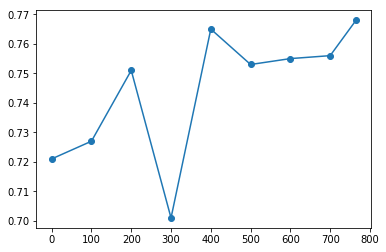

0.001
Start of epoch:  5
Iteration 0, loss = 0.7359
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)

Iteration 100, loss = 0.9020
Checking accuracy on validation set
Got 750 / 1000 correct (75.00)

Iteration 200, loss = 0.7340
Checking accuracy on validation set
Got 768 / 1000 correct (76.80)

Iteration 300, loss = 0.5738
Checking accuracy on validation set
Got 768 / 1000 correct (76.80)

Iteration 400, loss = 0.6393
Checking accuracy on validation set
Got 800 / 1000 correct (80.00)

Iteration 500, loss = 0.6806
Checking accuracy on validation set
Got 800 / 1000 correct (80.00)

Iteration 600, loss = 0.7194
Checking accuracy on validation set
Got 775 / 1000 correct (77.50)

Iteration 700, loss = 0.7555
Checking accuracy on validation set
Got 730 / 1000 correct (73.00)

Accuracy after epoch  5
Checking accuracy on validation set
Got 795 / 1000 correct (79.50)


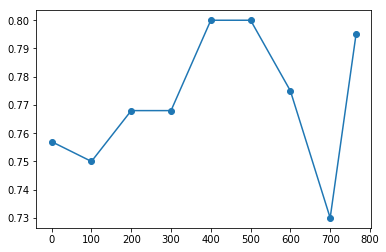

0.001
Start of epoch:  6
Iteration 0, loss = 0.6469
Checking accuracy on validation set
Got 792 / 1000 correct (79.20)

Iteration 100, loss = 0.5163
Checking accuracy on validation set
Got 792 / 1000 correct (79.20)

Iteration 200, loss = 0.6380
Checking accuracy on validation set
Got 774 / 1000 correct (77.40)

Iteration 300, loss = 0.7126
Checking accuracy on validation set
Got 797 / 1000 correct (79.70)

Iteration 400, loss = 0.7027
Checking accuracy on validation set
Got 787 / 1000 correct (78.70)

Iteration 500, loss = 0.6700
Checking accuracy on validation set
Got 810 / 1000 correct (81.00)

Iteration 600, loss = 0.7854
Checking accuracy on validation set
Got 795 / 1000 correct (79.50)

Iteration 700, loss = 0.5953
Checking accuracy on validation set
Got 820 / 1000 correct (82.00)

Accuracy after epoch  6
Checking accuracy on validation set
Got 779 / 1000 correct (77.90)


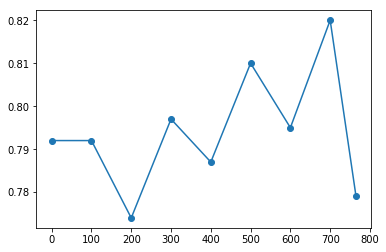

0.001
Start of epoch:  7
Iteration 0, loss = 0.8602
Checking accuracy on validation set
Got 785 / 1000 correct (78.50)

Iteration 100, loss = 0.8991
Checking accuracy on validation set
Got 796 / 1000 correct (79.60)

Iteration 200, loss = 0.6866
Checking accuracy on validation set
Got 783 / 1000 correct (78.30)

Iteration 300, loss = 0.6998
Checking accuracy on validation set
Got 799 / 1000 correct (79.90)

Iteration 400, loss = 0.9045
Checking accuracy on validation set
Got 808 / 1000 correct (80.80)

Iteration 500, loss = 0.7545
Checking accuracy on validation set
Got 799 / 1000 correct (79.90)

Iteration 600, loss = 0.8405
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)

Iteration 700, loss = 0.6223
Checking accuracy on validation set
Got 807 / 1000 correct (80.70)

Accuracy after epoch  7
Checking accuracy on validation set
Got 822 / 1000 correct (82.20)


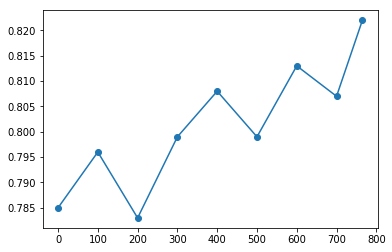

0.001
Start of epoch:  8
Iteration 0, loss = 0.5698
Checking accuracy on validation set
Got 812 / 1000 correct (81.20)

Iteration 100, loss = 0.5931
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Iteration 200, loss = 0.7654
Checking accuracy on validation set
Got 811 / 1000 correct (81.10)

Iteration 300, loss = 0.9105
Checking accuracy on validation set
Got 787 / 1000 correct (78.70)

Iteration 400, loss = 0.6548
Checking accuracy on validation set
Got 799 / 1000 correct (79.90)

Iteration 500, loss = 0.7072
Checking accuracy on validation set
Got 801 / 1000 correct (80.10)

Iteration 600, loss = 0.6242
Checking accuracy on validation set
Got 802 / 1000 correct (80.20)

Iteration 700, loss = 0.6785
Checking accuracy on validation set
Got 799 / 1000 correct (79.90)

Accuracy after epoch  8
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)


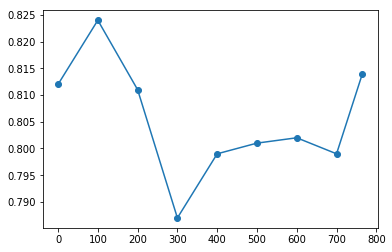

0.001
Start of epoch:  9
Iteration 0, loss = 0.8643
Checking accuracy on validation set
Got 812 / 1000 correct (81.20)

Iteration 100, loss = 0.6105
Checking accuracy on validation set
Got 820 / 1000 correct (82.00)

Iteration 200, loss = 0.5732
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)

Iteration 300, loss = 0.5741
Checking accuracy on validation set
Got 811 / 1000 correct (81.10)

Iteration 400, loss = 0.6731
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)

Iteration 500, loss = 0.3915
Checking accuracy on validation set
Got 806 / 1000 correct (80.60)

Iteration 600, loss = 0.4730
Checking accuracy on validation set
Got 784 / 1000 correct (78.40)

Iteration 700, loss = 0.7030
Checking accuracy on validation set
Got 820 / 1000 correct (82.00)

Accuracy after epoch  9
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)


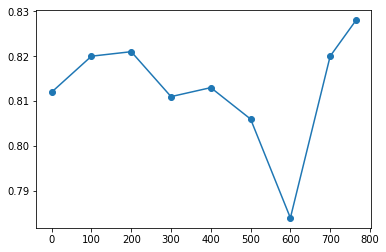

0.001
Start of epoch:  10
Iteration 0, loss = 0.6167
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Iteration 100, loss = 0.6720
Checking accuracy on validation set
Got 799 / 1000 correct (79.90)

Iteration 200, loss = 0.6328
Checking accuracy on validation set
Got 822 / 1000 correct (82.20)

Iteration 300, loss = 0.6300
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Iteration 400, loss = 0.8741
Checking accuracy on validation set
Got 815 / 1000 correct (81.50)

Iteration 500, loss = 0.6251
Checking accuracy on validation set
Got 811 / 1000 correct (81.10)

Iteration 600, loss = 0.4001
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)

Iteration 700, loss = 0.7015
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Accuracy after epoch  10
Checking accuracy on validation set
Got 825 / 1000 correct (82.50)


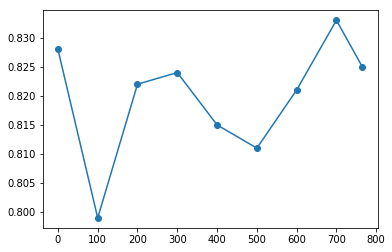

0.001
Start of epoch:  11
Iteration 0, loss = 0.7687
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Iteration 100, loss = 0.6326
Checking accuracy on validation set
Got 822 / 1000 correct (82.20)

Iteration 200, loss = 0.6006
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)

Iteration 300, loss = 0.5833
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Iteration 400, loss = 0.6028
Checking accuracy on validation set
Got 822 / 1000 correct (82.20)

Iteration 500, loss = 0.5379
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)

Iteration 600, loss = 0.6762
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)

Iteration 700, loss = 0.7023
Checking accuracy on validation set
Got 825 / 1000 correct (82.50)

Accuracy after epoch  11
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)


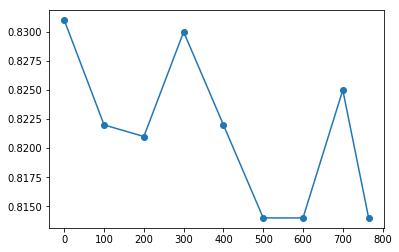

0.001
Start of epoch:  12
Iteration 0, loss = 0.6282
Checking accuracy on validation set
Got 820 / 1000 correct (82.00)

Iteration 100, loss = 0.6488
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Iteration 200, loss = 0.5811
Checking accuracy on validation set
Got 820 / 1000 correct (82.00)

Iteration 300, loss = 0.5019
Checking accuracy on validation set
Got 823 / 1000 correct (82.30)

Iteration 400, loss = 0.4867
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Iteration 500, loss = 0.6845
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Iteration 600, loss = 0.8192
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Iteration 700, loss = 0.6582
Checking accuracy on validation set
Got 823 / 1000 correct (82.30)

Accuracy after epoch  12
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)


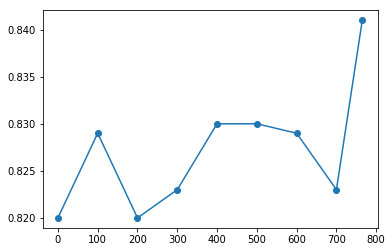

0.001
Start of epoch:  13
Iteration 0, loss = 0.6170
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Iteration 100, loss = 0.4449
Checking accuracy on validation set
Got 818 / 1000 correct (81.80)

Iteration 200, loss = 0.4593
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Iteration 300, loss = 0.6522
Checking accuracy on validation set
Got 825 / 1000 correct (82.50)

Iteration 400, loss = 0.5728
Checking accuracy on validation set
Got 819 / 1000 correct (81.90)

Iteration 500, loss = 0.7390
Checking accuracy on validation set
Got 811 / 1000 correct (81.10)

Iteration 600, loss = 0.5716
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Iteration 700, loss = 0.7311
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Accuracy after epoch  13
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)


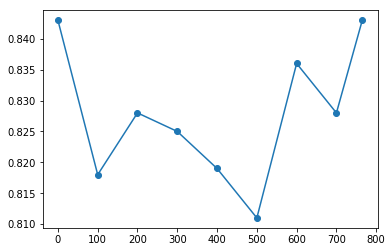

0.001
Start of epoch:  14
Iteration 0, loss = 0.4045
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Iteration 100, loss = 0.5423
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Iteration 200, loss = 0.5639
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)

Iteration 300, loss = 0.5501
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Iteration 400, loss = 0.5113
Checking accuracy on validation set
Got 826 / 1000 correct (82.60)

Iteration 500, loss = 0.4669
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Iteration 600, loss = 0.4995
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Iteration 700, loss = 0.6196
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Accuracy after epoch  14
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)


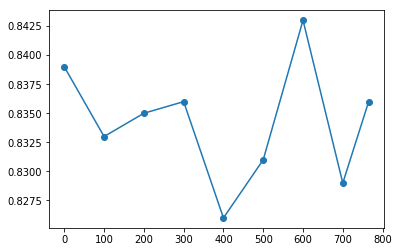

0.001
Start of epoch:  15
Iteration 0, loss = 0.5868
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Iteration 100, loss = 0.5163
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Iteration 200, loss = 0.8613
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Iteration 300, loss = 0.3168
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Iteration 400, loss = 0.5822
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)

Iteration 500, loss = 0.3656
Checking accuracy on validation set
Got 838 / 1000 correct (83.80)

Iteration 600, loss = 0.3054
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Iteration 700, loss = 0.4211
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Accuracy after epoch  15
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)


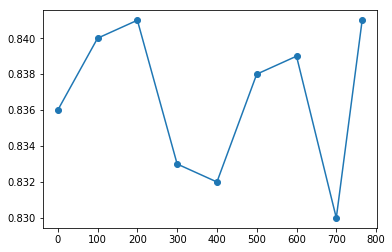

0.001
Start of epoch:  16
Iteration 0, loss = 0.4177
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Iteration 100, loss = 0.5613
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Iteration 200, loss = 0.4785
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Iteration 300, loss = 0.4862
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Iteration 400, loss = 0.3821
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Iteration 500, loss = 0.6205
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Iteration 600, loss = 0.5535
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Iteration 700, loss = 0.7471
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Accuracy after epoch  16
Checking accuracy on validation set
Got 819 / 1000 correct (81.90)


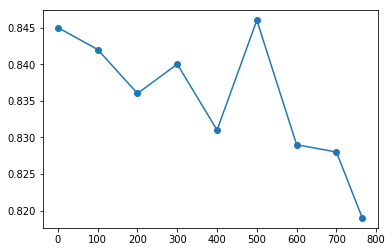

0.001
Start of epoch:  17
Iteration 0, loss = 0.4730
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Iteration 100, loss = 0.5465
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Iteration 200, loss = 0.5983
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Iteration 300, loss = 0.3908
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)

Iteration 400, loss = 0.8134
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Iteration 500, loss = 0.4187
Checking accuracy on validation set
Got 823 / 1000 correct (82.30)

Iteration 600, loss = 0.4356
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Iteration 700, loss = 0.4980
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Accuracy after epoch  17
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)


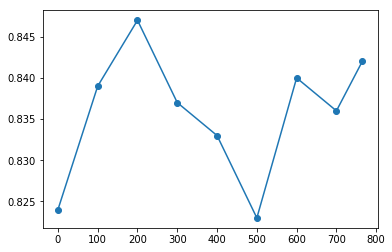

0.001
Start of epoch:  18
Iteration 0, loss = 0.5555
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Iteration 100, loss = 0.4088
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Iteration 200, loss = 0.4635
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)

Iteration 300, loss = 0.4237
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Iteration 400, loss = 0.3685
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Iteration 500, loss = 0.4097
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)

Iteration 600, loss = 0.5316
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Iteration 700, loss = 0.5055
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Accuracy after epoch  18
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)


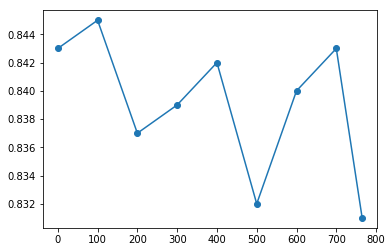

0.001
Start of epoch:  19
Iteration 0, loss = 0.3282
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Iteration 100, loss = 0.3552
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)

Iteration 200, loss = 0.5653
Checking accuracy on validation set
Got 838 / 1000 correct (83.80)

Iteration 300, loss = 0.5012
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Iteration 400, loss = 0.4732
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)

Iteration 500, loss = 0.4886
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Iteration 600, loss = 0.7084
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Iteration 700, loss = 0.3658
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Accuracy after epoch  19
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)


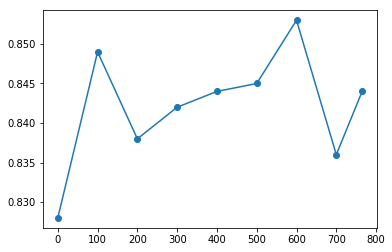

0.001
Start of epoch:  20
Iteration 0, loss = 0.4466
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Iteration 100, loss = 0.3241
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Iteration 200, loss = 0.3750
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Iteration 300, loss = 0.3784
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Iteration 400, loss = 0.3291
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Iteration 500, loss = 0.2312
Checking accuracy on validation set
Got 838 / 1000 correct (83.80)

Iteration 600, loss = 0.5408
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)

Iteration 700, loss = 0.3828
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Accuracy after epoch  20
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)


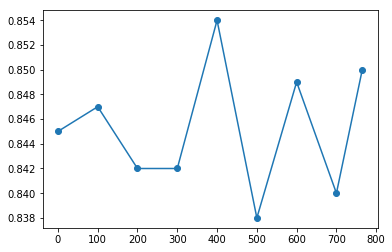

0.001
Start of epoch:  21
Iteration 0, loss = 0.4060
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)

Iteration 100, loss = 0.5154
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Iteration 200, loss = 0.4674
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Iteration 300, loss = 0.6545
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)

Iteration 400, loss = 0.4646
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Iteration 500, loss = 0.5346
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)

Iteration 600, loss = 0.5477
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 700, loss = 0.6329
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Accuracy after epoch  21
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)


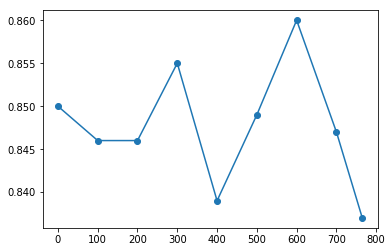

0.001
Start of epoch:  22
Iteration 0, loss = 0.2339
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Iteration 100, loss = 0.5003
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 200, loss = 0.4904
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 300, loss = 0.4040
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)

Iteration 400, loss = 0.3427
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 500, loss = 0.6883
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)

Iteration 600, loss = 0.3466
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 700, loss = 0.3713
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Accuracy after epoch  22
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)


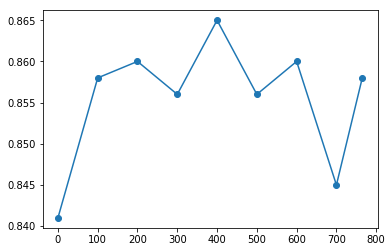

0.0005
Start of epoch:  23
Iteration 0, loss = 0.3714
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)

Iteration 100, loss = 0.3891
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Iteration 200, loss = 0.4633
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 300, loss = 0.3313
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 400, loss = 0.3684
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 500, loss = 0.2882
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 600, loss = 0.3044
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Iteration 700, loss = 0.3455
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  23
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)


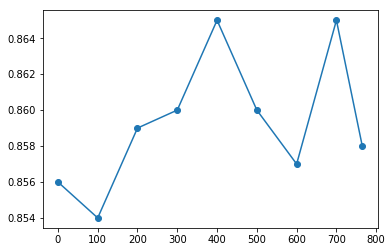

0.0005
Start of epoch:  24
Iteration 0, loss = 0.4176
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)

Iteration 100, loss = 0.4801
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 200, loss = 0.3513
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 300, loss = 0.3536
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 400, loss = 0.3301
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Iteration 500, loss = 0.3577
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 600, loss = 0.2013
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Iteration 700, loss = 0.5370
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Accuracy after epoch  24
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


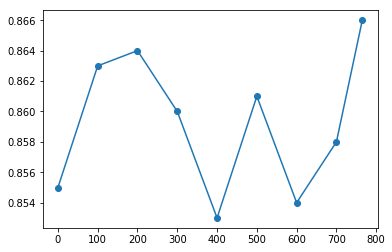

0.0005
Start of epoch:  25
Iteration 0, loss = 0.4640
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.3338
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.2643
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Iteration 300, loss = 0.4187
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 400, loss = 0.4499
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 500, loss = 0.4168
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 600, loss = 0.4775
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 700, loss = 0.2992
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Accuracy after epoch  25
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)


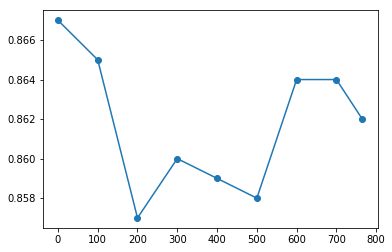

0.0005
Start of epoch:  26
Iteration 0, loss = 0.5544
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 100, loss = 0.6180
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 200, loss = 0.4384
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 300, loss = 0.6230
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 400, loss = 0.3242
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 500, loss = 0.3672
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 600, loss = 0.3864
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 700, loss = 0.3618
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  26
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


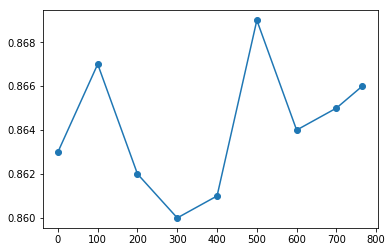

0.0005
Start of epoch:  27
Iteration 0, loss = 0.2714
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.2895
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.4365
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 300, loss = 0.3838
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 400, loss = 0.4014
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 500, loss = 0.4338
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 600, loss = 0.3363
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 700, loss = 0.2095
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Accuracy after epoch  27
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


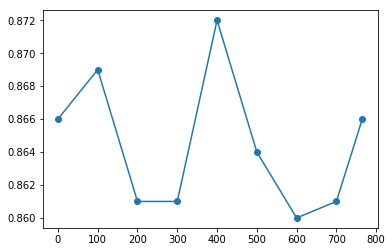

0.0005
Start of epoch:  28
Iteration 0, loss = 0.2447
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.3636
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.3731
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 300, loss = 0.3570
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.3605
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.4221
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 600, loss = 0.4341
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 700, loss = 0.5343
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Accuracy after epoch  28
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


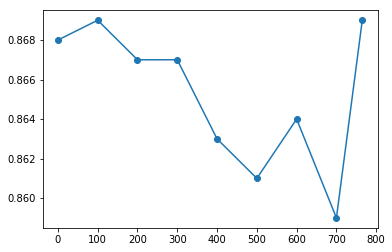

0.0005
Start of epoch:  29
Iteration 0, loss = 0.3494
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.4389
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 200, loss = 0.2471
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 300, loss = 0.5041
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.5230
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 500, loss = 0.3798
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 600, loss = 0.4268
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.2189
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Accuracy after epoch  29
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)


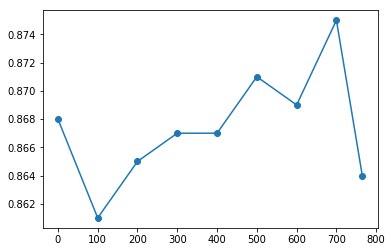

0.0005
Start of epoch:  30
Iteration 0, loss = 0.3318
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 100, loss = 0.4477
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 200, loss = 0.3602
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 300, loss = 0.2770
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 400, loss = 0.4673
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.4549
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.3922
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.3923
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Accuracy after epoch  30
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


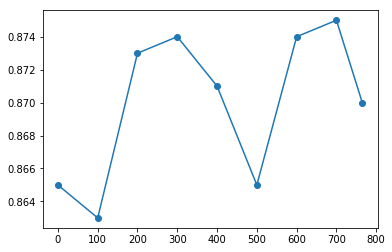

0.0005
Start of epoch:  31
Iteration 0, loss = 0.4049
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.3485
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.3125
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.3937
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 400, loss = 0.1793
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 500, loss = 0.2290
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.4088
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 700, loss = 0.3869
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Accuracy after epoch  31
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)


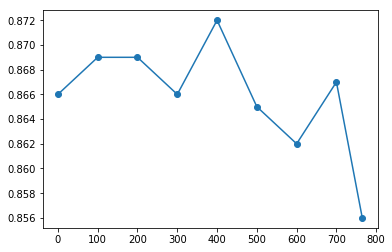

0.0005
Start of epoch:  32
Iteration 0, loss = 0.2789
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Iteration 100, loss = 0.2504
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 200, loss = 0.2626
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.3737
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 400, loss = 0.5673
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 500, loss = 0.6143
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 600, loss = 0.3614
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 700, loss = 0.2266
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Accuracy after epoch  32
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)


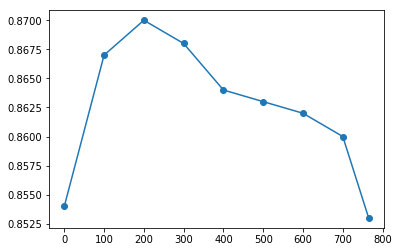

0.0005
Start of epoch:  33
Iteration 0, loss = 0.4071
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Iteration 100, loss = 0.3197
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 200, loss = 0.3552
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 300, loss = 0.3937
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 400, loss = 0.2720
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 500, loss = 0.6048
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 600, loss = 0.2989
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 700, loss = 0.3672
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Accuracy after epoch  33
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)


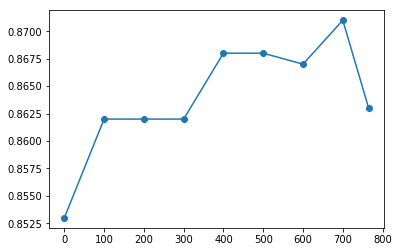

0.0005
Start of epoch:  34
Iteration 0, loss = 0.4204
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 100, loss = 0.3096
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.3893
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 300, loss = 0.2013
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 400, loss = 0.1930
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.1647
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 600, loss = 0.3127
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 700, loss = 0.2911
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  34
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


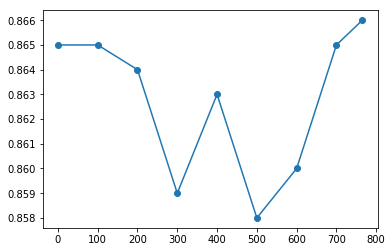

0.0005
Start of epoch:  35
Iteration 0, loss = 0.4411
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 100, loss = 0.3286
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 200, loss = 0.3490
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.3761
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 400, loss = 0.5044
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 500, loss = 0.3253
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 600, loss = 0.3384
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 700, loss = 0.2410
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Accuracy after epoch  35
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)


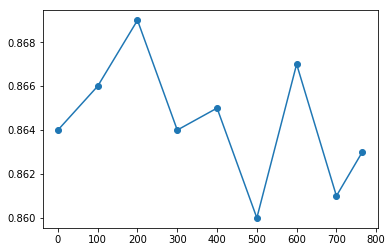

0.0005
Start of epoch:  36
Iteration 0, loss = 0.2225
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 100, loss = 0.4890
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 200, loss = 0.1855
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 300, loss = 0.3832
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 400, loss = 0.4633
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 500, loss = 0.3175
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)

Iteration 600, loss = 0.3237
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 700, loss = 0.4843
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  36
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)


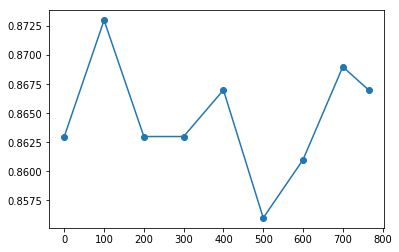

0.0005
Start of epoch:  37
Iteration 0, loss = 0.2975
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 100, loss = 0.2613
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 200, loss = 0.2902
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 300, loss = 0.2475
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 400, loss = 0.4246
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 500, loss = 0.3845
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 600, loss = 0.4088
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.4219
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Accuracy after epoch  37
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


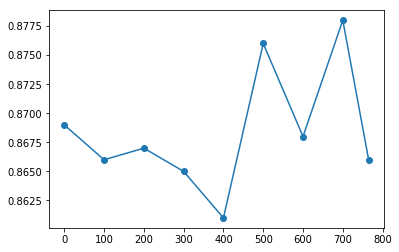

0.0005
Start of epoch:  38
Iteration 0, loss = 0.2417
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.3399
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 200, loss = 0.3436
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 300, loss = 0.3169
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.2598
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 500, loss = 0.2365
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 600, loss = 0.3737
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.2286
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Accuracy after epoch  38
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)


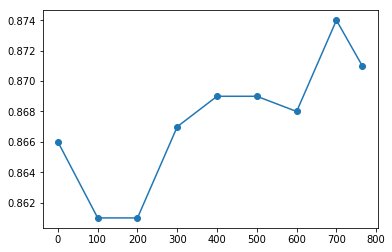

0.0005
Start of epoch:  39
Iteration 0, loss = 0.3707
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.2772
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 200, loss = 0.3453
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 300, loss = 0.3902
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 400, loss = 0.3366
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 500, loss = 0.3875
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 600, loss = 0.3302
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 700, loss = 0.2559
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)

Accuracy after epoch  39
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


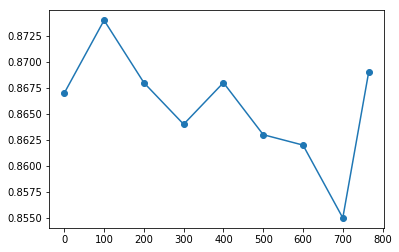

0.0005
Start of epoch:  40
Iteration 0, loss = 0.3350
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 100, loss = 0.3254
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.2134
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.3805
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 400, loss = 0.1866
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 500, loss = 0.2372
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 600, loss = 0.4121
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 700, loss = 0.2774
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Accuracy after epoch  40
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


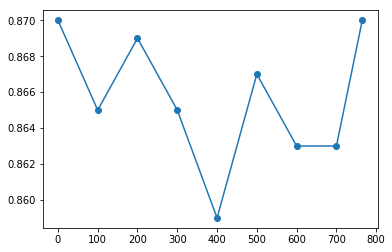

0.0005
Start of epoch:  41
Iteration 0, loss = 0.3129
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 100, loss = 0.2593
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 200, loss = 0.4152
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 300, loss = 0.3103
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.2649
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.3071
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 600, loss = 0.3252
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 700, loss = 0.1836
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Accuracy after epoch  41
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)


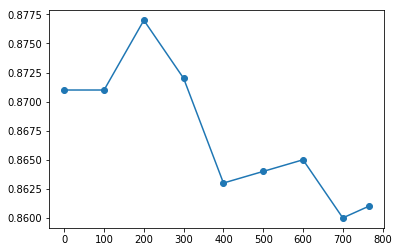

0.0005
Start of epoch:  42
Iteration 0, loss = 0.3298
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 100, loss = 0.3059
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 200, loss = 0.3062
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 300, loss = 0.2969
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 400, loss = 0.2510
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 500, loss = 0.1948
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 600, loss = 0.5568
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 700, loss = 0.2475
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Accuracy after epoch  42
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)


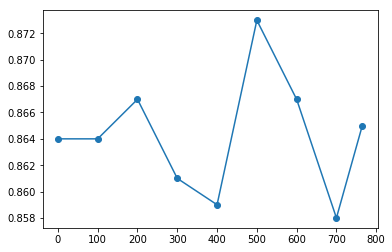

0.0005
Start of epoch:  43
Iteration 0, loss = 0.3952
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 100, loss = 0.2296
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 200, loss = 0.1749
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.3441
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.4979
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 500, loss = 0.2778
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 600, loss = 0.2770
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 700, loss = 0.1424
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  43
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)


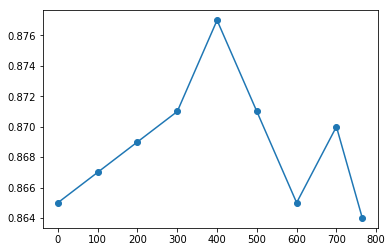

0.0005
Start of epoch:  44
Iteration 0, loss = 0.3269
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.2549
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 200, loss = 0.3244
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 300, loss = 0.1444
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.4995
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 500, loss = 0.3654
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 600, loss = 0.2608
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 700, loss = 0.3595
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  44
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)


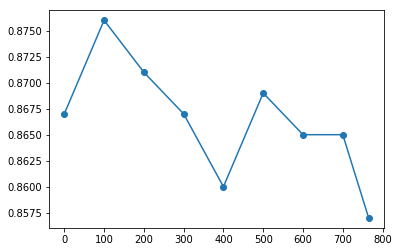

0.0005
Start of epoch:  45
Iteration 0, loss = 0.4282
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 100, loss = 0.3718
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 200, loss = 0.3289
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.1622
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 400, loss = 0.2676
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 500, loss = 0.3183
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 600, loss = 0.2544
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 700, loss = 0.3575
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Accuracy after epoch  45
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)


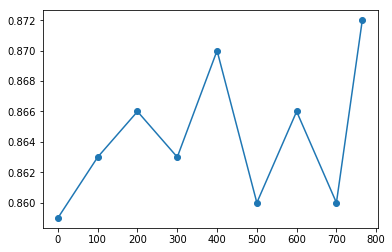

0.0005
Start of epoch:  46
Iteration 0, loss = 0.4022
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.2237
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 200, loss = 0.3885
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 300, loss = 0.3913
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 400, loss = 0.1943
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 500, loss = 0.2145
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 600, loss = 0.2448
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.2023
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Accuracy after epoch  46
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)


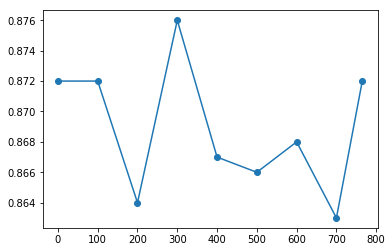

0.0005
Start of epoch:  47
Iteration 0, loss = 0.3516
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 100, loss = 0.2690
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 200, loss = 0.2123
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 300, loss = 0.3520
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.3590
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.3217
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 600, loss = 0.2565
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 700, loss = 0.5333
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Accuracy after epoch  47
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


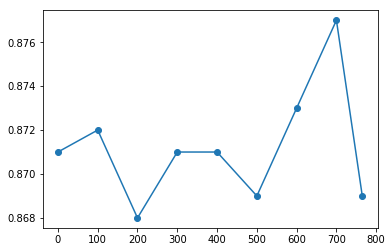

0.0005
Start of epoch:  48
Iteration 0, loss = 0.3368
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.4505
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 200, loss = 0.5380
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 300, loss = 0.4063
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.2394
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 500, loss = 0.2746
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 600, loss = 0.3109
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 700, loss = 0.3822
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Accuracy after epoch  48
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)


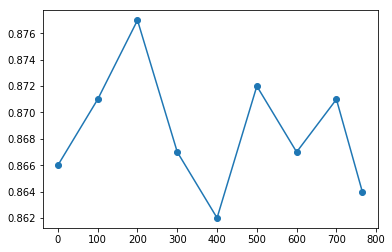

0.0005
Start of epoch:  49
Iteration 0, loss = 0.2478
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 100, loss = 0.3297
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.3458
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 300, loss = 0.2276
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 400, loss = 0.1407
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.2071
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 600, loss = 0.3157
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 700, loss = 0.2552
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Accuracy after epoch  49
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)


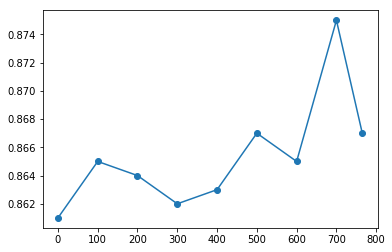

0.0005
Start of epoch:  50
Iteration 0, loss = 0.3216
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.2426
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.2438
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.4197
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.3251
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 500, loss = 0.4288
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 600, loss = 0.3452
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.1991
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  50
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


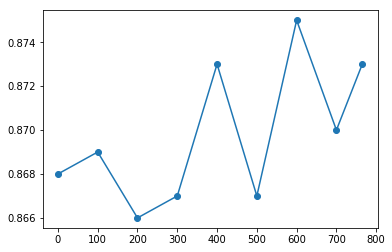

0.0005
Start of epoch:  51
Iteration 0, loss = 0.5217
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 100, loss = 0.3576
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.4066
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 300, loss = 0.2844
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 400, loss = 0.1873
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 500, loss = 0.1926
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 600, loss = 0.1482
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 700, loss = 0.3466
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  51
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)


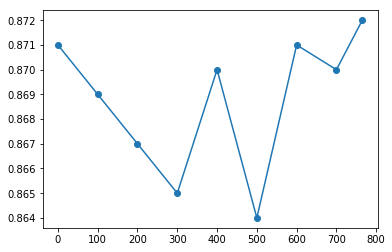

0.0005
Start of epoch:  52
Iteration 0, loss = 0.4096
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.2643
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.2580
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 300, loss = 0.3073
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 400, loss = 0.1576
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 500, loss = 0.3307
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 600, loss = 0.1242
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 700, loss = 0.5503
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Accuracy after epoch  52
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


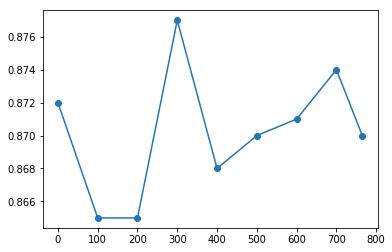

0.0005
Start of epoch:  53
Iteration 0, loss = 0.4446
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.3922
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 200, loss = 0.4094
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 300, loss = 0.2041
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 400, loss = 0.3806
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 500, loss = 0.4119
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 600, loss = 0.2950
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.3190
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  53
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


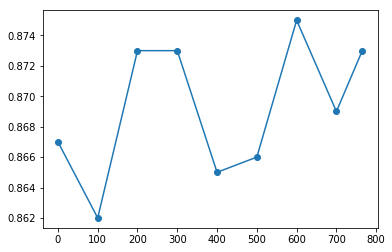

0.0005
Start of epoch:  54
Iteration 0, loss = 0.2616
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 100, loss = 0.3030
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 200, loss = 0.3434
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.3219
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.3960
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 500, loss = 0.3718
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 600, loss = 0.3179
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.5871
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Accuracy after epoch  54
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


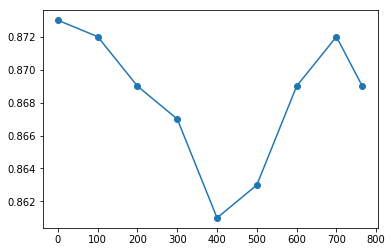

0.0005
Start of epoch:  55
Iteration 0, loss = 0.2111
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.1473
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 200, loss = 0.2839
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 300, loss = 0.3808
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.2390
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.4539
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 600, loss = 0.2718
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 700, loss = 0.3698
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  55
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


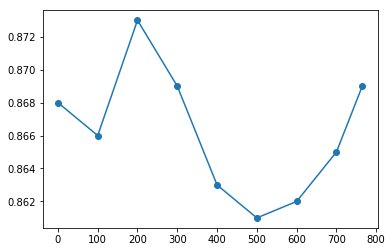

0.0005
Start of epoch:  56
Iteration 0, loss = 0.5191
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.1578
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 200, loss = 0.1577
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 300, loss = 0.3824
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 400, loss = 0.2072
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 500, loss = 0.4620
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 600, loss = 0.2861
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.3539
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Accuracy after epoch  56
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)


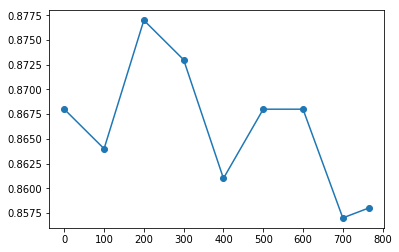

0.0005
Start of epoch:  57
Iteration 0, loss = 0.2897
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 100, loss = 0.2775
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 200, loss = 0.4911
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.2657
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 400, loss = 0.3472
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 500, loss = 0.4239
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 600, loss = 0.3271
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Iteration 700, loss = 0.2929
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Accuracy after epoch  57
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)


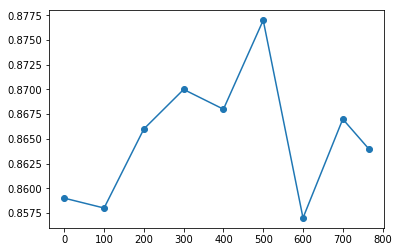

0.0005
Start of epoch:  58
Iteration 0, loss = 0.4324
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.3280
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 200, loss = 0.2803
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 300, loss = 0.2130
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 400, loss = 0.2717
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 500, loss = 0.3207
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 600, loss = 0.2856
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 700, loss = 0.4944
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  58
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)


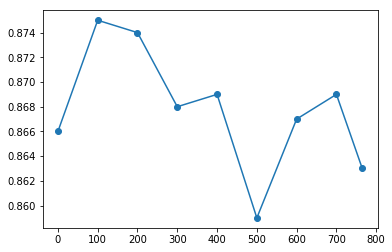

0.0005
Start of epoch:  59
Iteration 0, loss = 0.4291
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 100, loss = 0.3438
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.1442
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 300, loss = 0.3277
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.2548
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.2695
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 600, loss = 0.2655
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 700, loss = 0.2551
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Accuracy after epoch  59
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)


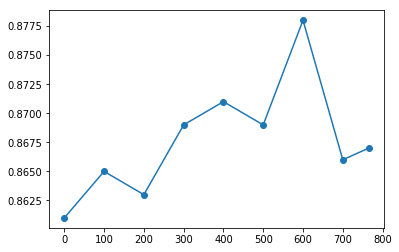

0.0005
Start of epoch:  60
Iteration 0, loss = 0.4502
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.3516
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 200, loss = 0.2895
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 300, loss = 0.2740
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 400, loss = 0.2819
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.3756
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 600, loss = 0.1890
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.2884
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Accuracy after epoch  60
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)


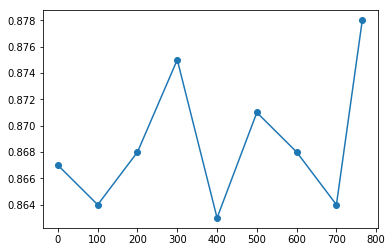

0.0005
Start of epoch:  61
Iteration 0, loss = 0.2336
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 100, loss = 0.2239
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 200, loss = 0.1668
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.2045
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 400, loss = 0.3228
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 500, loss = 0.2333
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.1752
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 700, loss = 0.3585
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Accuracy after epoch  61
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


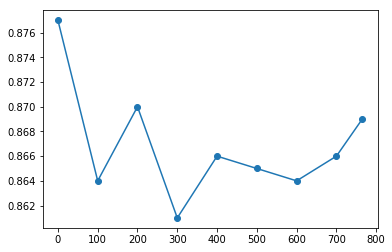

0.0005
Start of epoch:  62
Iteration 0, loss = 0.5244
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.3520
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 200, loss = 0.1833
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 300, loss = 0.4073
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 400, loss = 0.3168
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.2265
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 600, loss = 0.3023
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.3823
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Accuracy after epoch  62
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


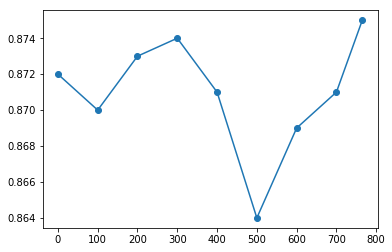

0.0005
Start of epoch:  63
Iteration 0, loss = 0.1879
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 100, loss = 0.3252
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 200, loss = 0.5355
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 300, loss = 0.3428
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 400, loss = 0.3053
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 500, loss = 0.2088
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.2799
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.3822
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Accuracy after epoch  63
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


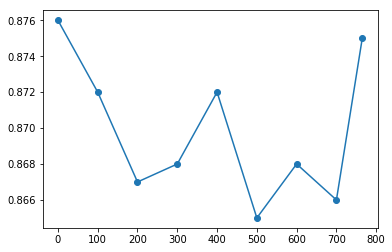

0.0005
Start of epoch:  64
Iteration 0, loss = 0.4162
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.2376
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.2388
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.2379
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 400, loss = 0.1973
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 500, loss = 0.1742
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Iteration 600, loss = 0.3591
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 700, loss = 0.2787
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)

Accuracy after epoch  64
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)


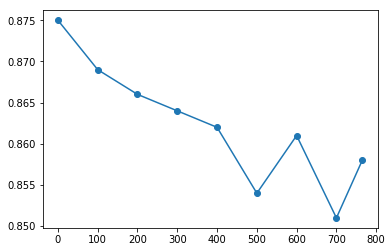

0.0005
Start of epoch:  65
Iteration 0, loss = 0.3093
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)

Iteration 100, loss = 0.3769
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 200, loss = 0.3341
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 300, loss = 0.2275
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 400, loss = 0.3151
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 500, loss = 0.2354
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 600, loss = 0.3307
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.2294
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  65
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)


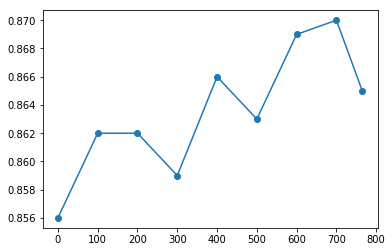

0.0005
Start of epoch:  66
Iteration 0, loss = 0.3594
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 100, loss = 0.3328
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 200, loss = 0.2206
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 300, loss = 0.2840
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.4195
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 500, loss = 0.3173
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 600, loss = 0.2130
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 700, loss = 0.3513
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Accuracy after epoch  66
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


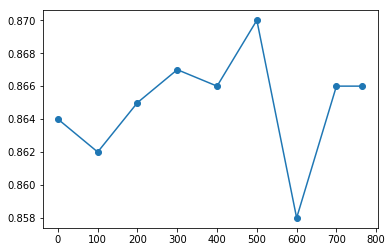

0.0005
Start of epoch:  67
Iteration 0, loss = 0.2341
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 100, loss = 0.2394
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 200, loss = 0.3211
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 300, loss = 0.5722
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Iteration 400, loss = 0.2918
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Iteration 500, loss = 0.3730
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.3148
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 700, loss = 0.2568
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Accuracy after epoch  67
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)


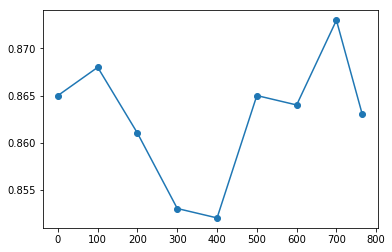

0.0005
Start of epoch:  68
Iteration 0, loss = 0.3448
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 100, loss = 0.3986
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 200, loss = 0.1864
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 300, loss = 0.2765
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.2016
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 500, loss = 0.3765
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 600, loss = 0.3924
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 700, loss = 0.2815
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  68
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)


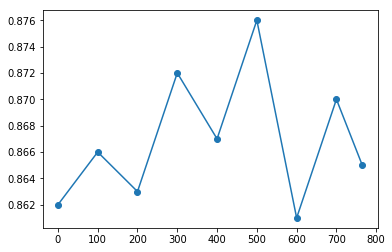

0.0005
Start of epoch:  69
Iteration 0, loss = 0.3481
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Iteration 100, loss = 0.3277
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.2845
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.3396
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 400, loss = 0.1838
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 500, loss = 0.5176
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 600, loss = 0.2762
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.3036
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Accuracy after epoch  69
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


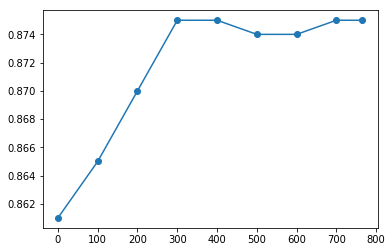

0.0005
Start of epoch:  70
Iteration 0, loss = 0.3498
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.1406
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 200, loss = 0.3948
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 300, loss = 0.3691
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 400, loss = 0.2022
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 500, loss = 0.3430
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 600, loss = 0.1963
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.2099
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  70
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)


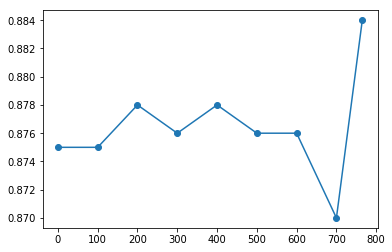

0.0005
Start of epoch:  71
Iteration 0, loss = 0.2215
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)

Iteration 100, loss = 0.2061
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 200, loss = 0.1616
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 300, loss = 0.3160
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 400, loss = 0.2180
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 500, loss = 0.2385
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 600, loss = 0.3241
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 700, loss = 0.3553
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Accuracy after epoch  71
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)


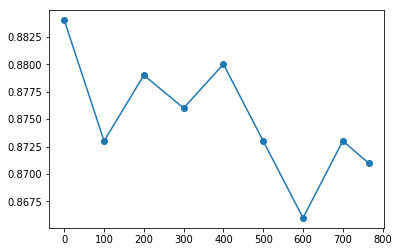

0.0005
Start of epoch:  72
Iteration 0, loss = 0.2264
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 100, loss = 0.1625
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 200, loss = 0.3785
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 300, loss = 0.3427
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 400, loss = 0.2333
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 500, loss = 0.3974
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 600, loss = 0.1944
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 700, loss = 0.2771
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Accuracy after epoch  72
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


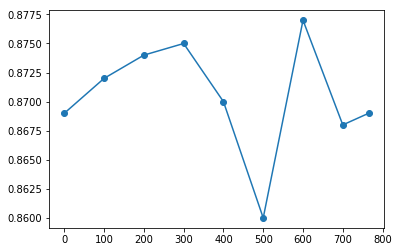

0.0005
Start of epoch:  73
Iteration 0, loss = 0.3151
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 100, loss = 0.4219
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 200, loss = 0.4023
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 300, loss = 0.1625
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.2717
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 500, loss = 0.2146
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 600, loss = 0.3202
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.2426
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Accuracy after epoch  73
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)


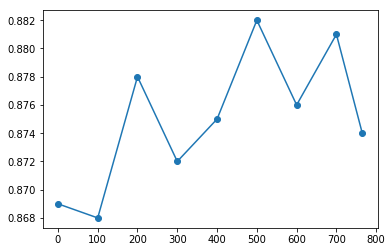

0.0005
Start of epoch:  74
Iteration 0, loss = 0.3410
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.2795
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 200, loss = 0.2183
Checking accuracy on validation set
Got 886 / 1000 correct (88.60)

Iteration 300, loss = 0.2731
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 400, loss = 0.2403
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 500, loss = 0.2891
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 600, loss = 0.3130
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.4079
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)

Accuracy after epoch  74
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)


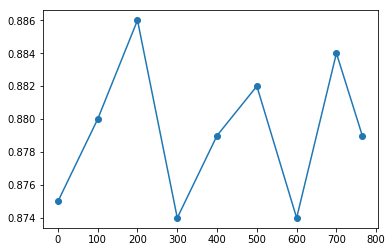

0.0005
Start of epoch:  75
Iteration 0, loss = 0.1899
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 100, loss = 0.3643
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 200, loss = 0.2780
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.2679
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 400, loss = 0.3239
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 500, loss = 0.5112
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 600, loss = 0.3172
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.2741
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Accuracy after epoch  75
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)


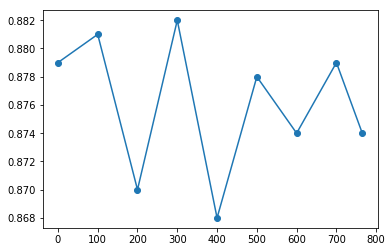

0.0005
Start of epoch:  76
Iteration 0, loss = 0.3543
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.3655
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 200, loss = 0.2146
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 300, loss = 0.2608
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 400, loss = 0.2644
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.3954
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 600, loss = 0.3482
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.1720
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Accuracy after epoch  76
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)


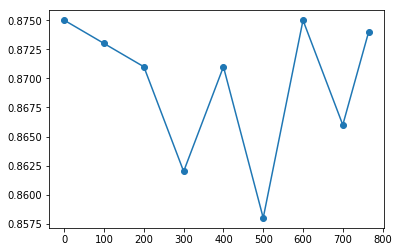

0.0005
Start of epoch:  77
Iteration 0, loss = 0.1892
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 100, loss = 0.3951
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 200, loss = 0.2726
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 300, loss = 0.2845
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 400, loss = 0.4490
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 500, loss = 0.2115
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.5236
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.4794
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  77
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)


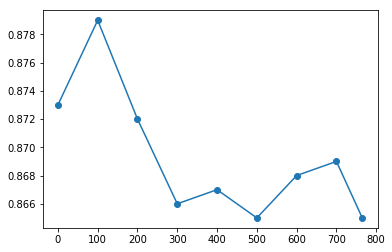

0.0005
Start of epoch:  78
Iteration 0, loss = 0.2469
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.3064
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 200, loss = 0.2682
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 300, loss = 0.3376
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.2640
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.3133
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 600, loss = 0.2209
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.3070
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Accuracy after epoch  78
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)


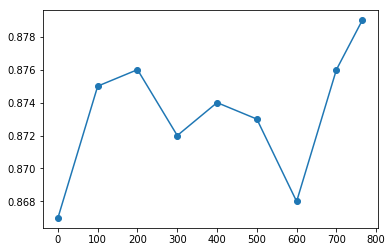

0.0005
Start of epoch:  79
Iteration 0, loss = 0.2903
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 100, loss = 0.2018
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 200, loss = 0.4730
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 300, loss = 0.1796
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.3401
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 500, loss = 0.2992
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.1888
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.2796
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Accuracy after epoch  79
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)


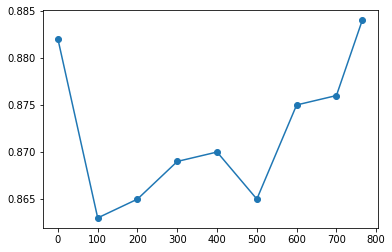

0.0005
Start of epoch:  80
Iteration 0, loss = 0.2754
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 100, loss = 0.1965
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 200, loss = 0.3999
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.1677
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 400, loss = 0.3140
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 500, loss = 0.3216
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 600, loss = 0.1421
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.2301
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Accuracy after epoch  80
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


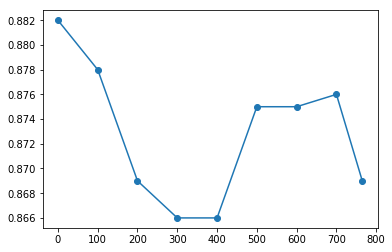

0.0005
Start of epoch:  81
Iteration 0, loss = 0.2616
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 100, loss = 0.2255
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 200, loss = 0.3033
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.2722
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.2184
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 500, loss = 0.2838
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 600, loss = 0.2454
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.2488
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  81
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


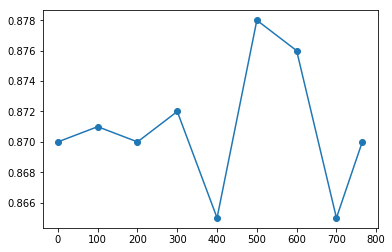

0.0005
Start of epoch:  82
Iteration 0, loss = 0.1425
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.2098
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.1963
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.3645
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.2545
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.2751
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 600, loss = 0.2786
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 700, loss = 0.1963
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Accuracy after epoch  82
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)


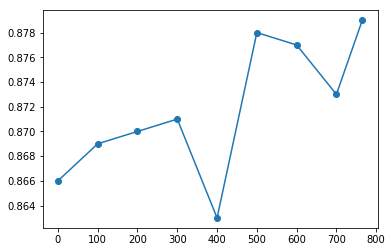

0.0005
Start of epoch:  83
Iteration 0, loss = 0.2523
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 100, loss = 0.2674
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 200, loss = 0.2912
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 300, loss = 0.3736
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 400, loss = 0.1644
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 500, loss = 0.2851
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 600, loss = 0.2332
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 700, loss = 0.3614
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Accuracy after epoch  83
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)


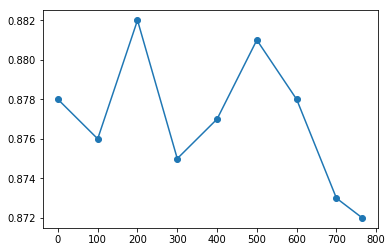

0.0005
Start of epoch:  84
Iteration 0, loss = 0.4595
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 100, loss = 0.3014
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 200, loss = 0.2477
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 300, loss = 0.1702
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.3273
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 500, loss = 0.1681
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 600, loss = 0.3349
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 700, loss = 0.4644
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Accuracy after epoch  84
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)


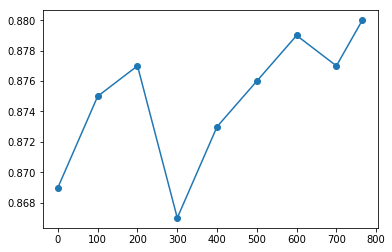

0.0005
Start of epoch:  85
Iteration 0, loss = 0.3390
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 100, loss = 0.3492
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 200, loss = 0.1668
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 300, loss = 0.2588
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 400, loss = 0.2197
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 500, loss = 0.2211
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 600, loss = 0.2493
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 700, loss = 0.1967
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  85
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)


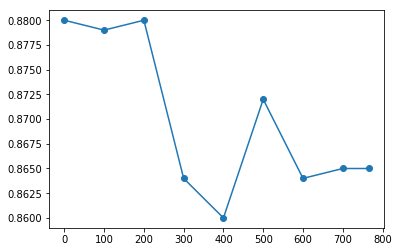

0.0005
Start of epoch:  86
Iteration 0, loss = 0.2165
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 100, loss = 0.1783
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 200, loss = 0.3293
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.1762
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 400, loss = 0.2589
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 500, loss = 0.2049
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 600, loss = 0.1291
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.2724
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Accuracy after epoch  86
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)


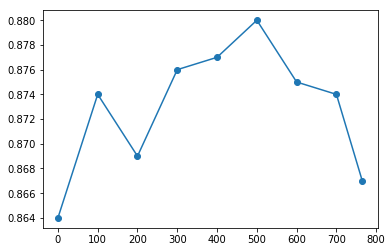

0.0005
Start of epoch:  87
Iteration 0, loss = 0.1758
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.1227
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 200, loss = 0.2575
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.1868
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 400, loss = 0.1991
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 500, loss = 0.4167
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 600, loss = 0.2306
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.1945
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Accuracy after epoch  87
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


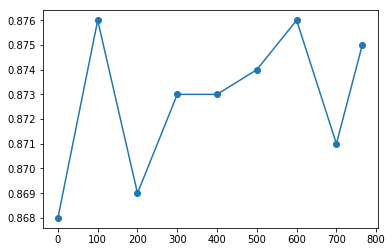

0.0005
Start of epoch:  88
Iteration 0, loss = 0.2283
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 100, loss = 0.2177
Checking accuracy on validation set
Got 885 / 1000 correct (88.50)

Iteration 200, loss = 0.0925
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 300, loss = 0.2562
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 400, loss = 0.3567
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 500, loss = 0.1986
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 600, loss = 0.4232
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 700, loss = 0.1184
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Accuracy after epoch  88
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)


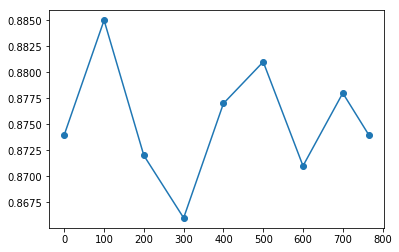

0.0005
Start of epoch:  89
Iteration 0, loss = 0.2769
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 100, loss = 0.2136
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 200, loss = 0.1989
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 300, loss = 0.2521
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 400, loss = 0.2590
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.4310
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 600, loss = 0.2891
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 700, loss = 0.4814
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Accuracy after epoch  89
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)


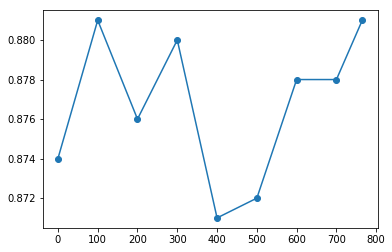

0.0005
Start of epoch:  90
Iteration 0, loss = 0.3793
Checking accuracy on validation set
Got 883 / 1000 correct (88.30)

Iteration 100, loss = 0.1987
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 200, loss = 0.2144
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 300, loss = 0.3941
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 400, loss = 0.3114
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 500, loss = 0.1925
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 600, loss = 0.3086
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 700, loss = 0.2745
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Accuracy after epoch  90
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)


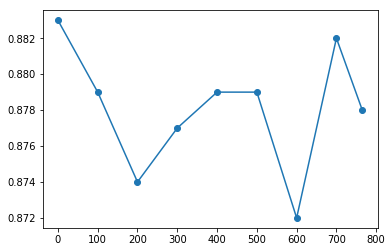

0.0005
Start of epoch:  91
Iteration 0, loss = 0.3619
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 100, loss = 0.2045
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 200, loss = 0.3364
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 300, loss = 0.1773
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.2045
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.2813
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 600, loss = 0.3094
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.2747
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Accuracy after epoch  91
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


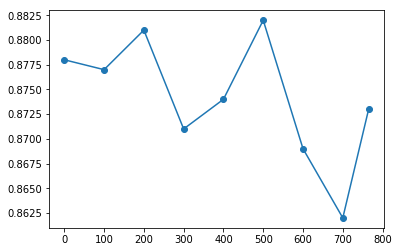

0.0005
Start of epoch:  92
Iteration 0, loss = 0.3473
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 100, loss = 0.2241
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 200, loss = 0.2831
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 300, loss = 0.2928
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 400, loss = 0.1926
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 500, loss = 0.2107
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 600, loss = 0.3185
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 700, loss = 0.2481
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  92
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)


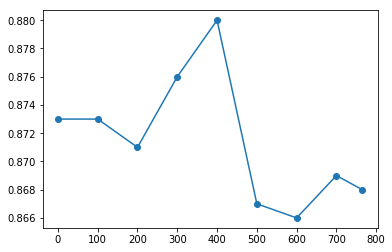

0.0005
Start of epoch:  93
Iteration 0, loss = 0.2161
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.3076
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 200, loss = 0.2248
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.2976
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 400, loss = 0.3286
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 500, loss = 0.3006
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 600, loss = 0.2898
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 700, loss = 0.1801
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Accuracy after epoch  93
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


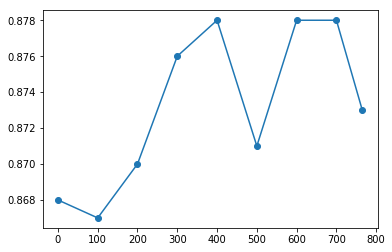

0.0005
Start of epoch:  94
Iteration 0, loss = 0.2513
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.3326
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.1151
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 300, loss = 0.3242
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 400, loss = 0.2453
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.2152
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 600, loss = 0.3287
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 700, loss = 0.2561
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Accuracy after epoch  94
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


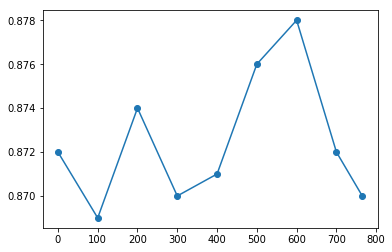

0.0005
Start of epoch:  95
Iteration 0, loss = 0.1874
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 100, loss = 0.3089
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 200, loss = 0.2267
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 300, loss = 0.2571
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 400, loss = 0.1317
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 500, loss = 0.2910
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 600, loss = 0.3004
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.2424
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Accuracy after epoch  95
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)


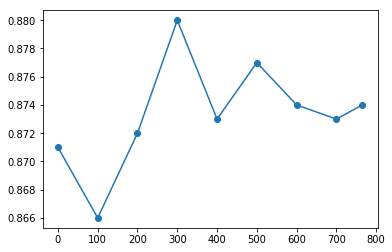

0.0005
Start of epoch:  96
Iteration 0, loss = 0.3518
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.2910
Checking accuracy on validation set
Got 885 / 1000 correct (88.50)

Iteration 200, loss = 0.2766
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 300, loss = 0.0651
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.2699
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 500, loss = 0.2119
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 600, loss = 0.1700
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.3045
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Accuracy after epoch  96
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)


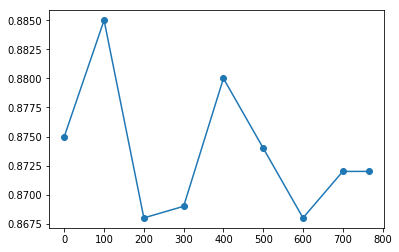

0.0005
Start of epoch:  97
Iteration 0, loss = 0.4296
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 100, loss = 0.2563
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 200, loss = 0.3426
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 300, loss = 0.4251
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 400, loss = 0.3237
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 500, loss = 0.2279
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 600, loss = 0.3105
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.1368
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  97
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)


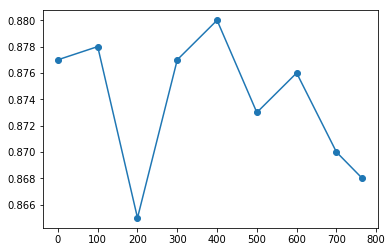

0.0005
Start of epoch:  98
Iteration 0, loss = 0.2455
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.3840
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 200, loss = 0.3119
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 300, loss = 0.3257
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.1828
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.1449
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 600, loss = 0.2881
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 700, loss = 0.2919
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Accuracy after epoch  98
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)


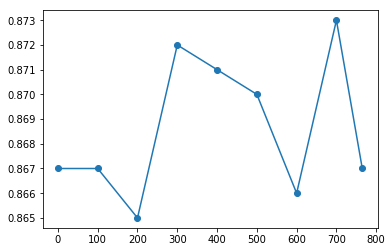

0.0005
Start of epoch:  99
Iteration 0, loss = 0.1852
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.1580
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 200, loss = 0.1008
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 300, loss = 0.1577
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.1129
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 500, loss = 0.2655
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 600, loss = 0.2419
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 700, loss = 0.2244
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  99
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


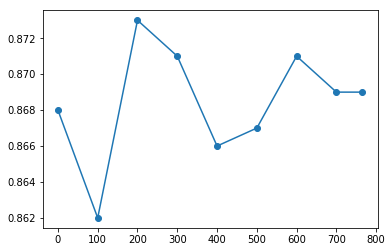

0.0005
Start of epoch:  100
Iteration 0, loss = 0.2026
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.2305
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Iteration 200, loss = 0.1790
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.2456
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.4499
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.1832
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 600, loss = 0.3278
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.2524
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  100
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


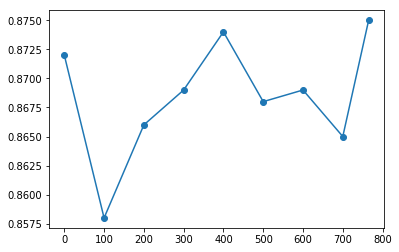

0.0005
Start of epoch:  101
Iteration 0, loss = 0.2067
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.3948
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 200, loss = 0.3949
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 300, loss = 0.2386
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 400, loss = 0.4060
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.1788
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 600, loss = 0.2316
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.3759
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  101
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)


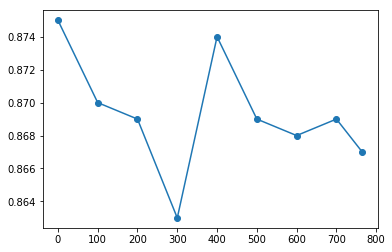

0.0005
Start of epoch:  102
Iteration 0, loss = 0.2004
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 100, loss = 0.3384
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 200, loss = 0.2435
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 300, loss = 0.3999
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 400, loss = 0.3005
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 500, loss = 0.3358
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 600, loss = 0.2967
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 700, loss = 0.3526
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  102
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)


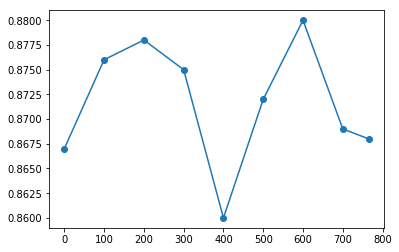

0.0005
Start of epoch:  103
Iteration 0, loss = 0.4923
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 100, loss = 0.2261
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 200, loss = 0.2991
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.2900
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 400, loss = 0.2122
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 500, loss = 0.2986
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 600, loss = 0.1971
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 700, loss = 0.2752
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Accuracy after epoch  103
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)


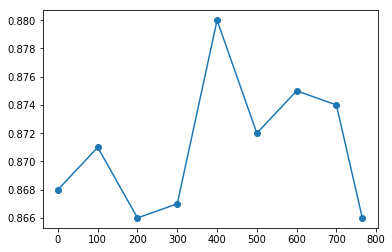

0.0005
Start of epoch:  104
Iteration 0, loss = 0.2435
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 100, loss = 0.2921
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 200, loss = 0.3173
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 300, loss = 0.2878
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 400, loss = 0.3033
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 500, loss = 0.2795
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 600, loss = 0.1784
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 700, loss = 0.2203
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Accuracy after epoch  104
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)


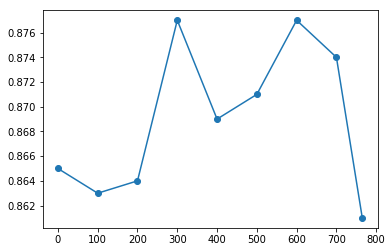

0.0005
Start of epoch:  105
Iteration 0, loss = 0.2660
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 100, loss = 0.3009
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 200, loss = 0.1376
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.1834
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 400, loss = 0.2576
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 500, loss = 0.1867
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 600, loss = 0.3880
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 700, loss = 0.2635
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Accuracy after epoch  105
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)


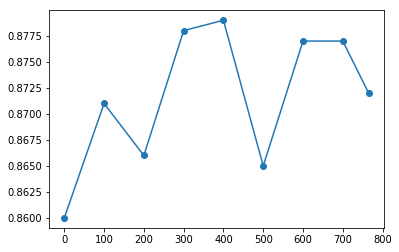

0.0005
Start of epoch:  106
Iteration 0, loss = 0.1469
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.2059
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.2164
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.3567
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 400, loss = 0.2105
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 500, loss = 0.4098
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 600, loss = 0.2708
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 700, loss = 0.1669
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Accuracy after epoch  106
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


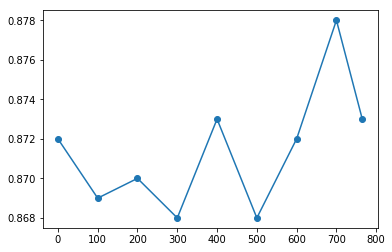

0.0005
Start of epoch:  107
Iteration 0, loss = 0.3159
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 100, loss = 0.3138
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 200, loss = 0.2684
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 300, loss = 0.1704
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 400, loss = 0.3480
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 500, loss = 0.3175
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 600, loss = 0.3635
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 700, loss = 0.2847
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  107
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


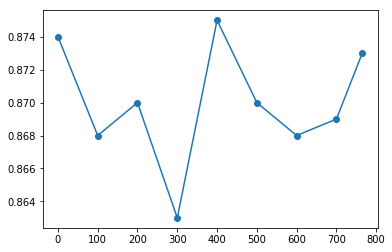

0.0005
Start of epoch:  108
Iteration 0, loss = 0.1581
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 100, loss = 0.3555
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.3001
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 300, loss = 0.3421
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 400, loss = 0.2042
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 500, loss = 0.2313
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 600, loss = 0.1575
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 700, loss = 0.3043
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Accuracy after epoch  108
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)


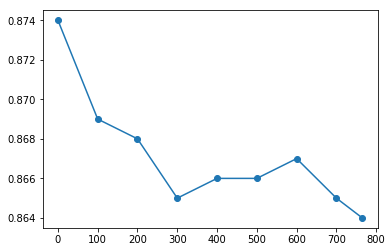

0.0005
Start of epoch:  109
Iteration 0, loss = 0.4150
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 100, loss = 0.3612
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 200, loss = 0.1042
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 300, loss = 0.2496
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 400, loss = 0.3841
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 500, loss = 0.3527
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 600, loss = 0.2729
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 700, loss = 0.3416
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Accuracy after epoch  109
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)


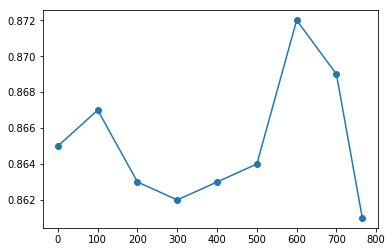

0.0005
Start of epoch:  110
Iteration 0, loss = 0.2117
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 100, loss = 0.1624
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Iteration 200, loss = 0.1618
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 300, loss = 0.3400
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 400, loss = 0.2263
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Iteration 500, loss = 0.3014
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 600, loss = 0.2812
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 700, loss = 0.3674
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Accuracy after epoch  110
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


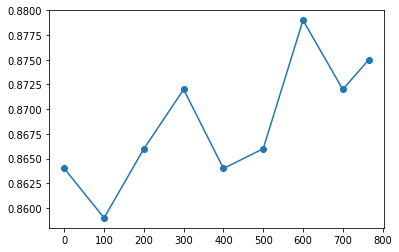

0.0005
Start of epoch:  111
Iteration 0, loss = 0.2213
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.1435
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 200, loss = 0.1681
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 300, loss = 0.2672
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 400, loss = 0.1871
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Iteration 500, loss = 0.3694
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 600, loss = 0.2792
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 700, loss = 0.1479
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Accuracy after epoch  111
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


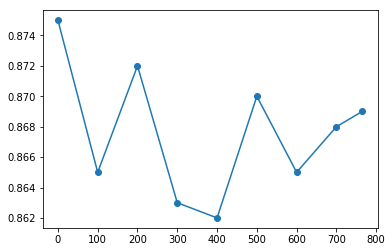

0.0005
Start of epoch:  112
Iteration 0, loss = 0.1833
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 100, loss = 0.2864
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 200, loss = 0.4049
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 300, loss = 0.2875
Checking accuracy on validation set
Got 883 / 1000 correct (88.30)

Iteration 400, loss = 0.4611
Checking accuracy on validation set
Got 883 / 1000 correct (88.30)

Iteration 500, loss = 0.4002
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 600, loss = 0.2143
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.1360
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Accuracy after epoch  112
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)


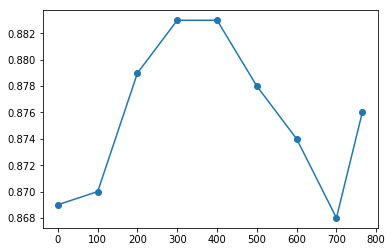

0.0005
Start of epoch:  113
Iteration 0, loss = 0.3441
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 100, loss = 0.1506
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 200, loss = 0.1873
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 300, loss = 0.1212
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 400, loss = 0.1751
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 500, loss = 0.2313
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)

Iteration 600, loss = 0.2723
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 700, loss = 0.2089
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Accuracy after epoch  113
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


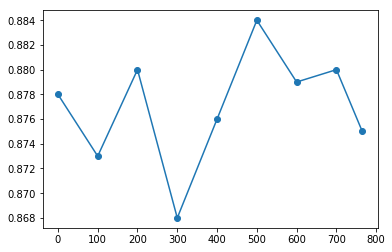

0.0005
Start of epoch:  114
Iteration 0, loss = 0.1848
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.4715
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 200, loss = 0.2600
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 300, loss = 0.2715
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 400, loss = 0.2412
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 500, loss = 0.2477
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 600, loss = 0.2266
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.1546
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Accuracy after epoch  114
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)


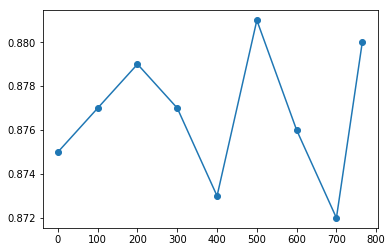

0.0005
Start of epoch:  115
Iteration 0, loss = 0.2278
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 100, loss = 0.1959
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 200, loss = 0.2173
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 300, loss = 0.2630
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 400, loss = 0.5076
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 500, loss = 0.2115
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 600, loss = 0.2101
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 700, loss = 0.3127
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Accuracy after epoch  115
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)


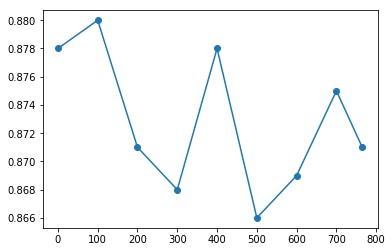

0.0005
Start of epoch:  116
Iteration 0, loss = 0.1516
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 100, loss = 0.1672
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 200, loss = 0.2388
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 300, loss = 0.1782
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 400, loss = 0.2546
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 500, loss = 0.3635
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 600, loss = 0.2952
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 700, loss = 0.2006
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Accuracy after epoch  116
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


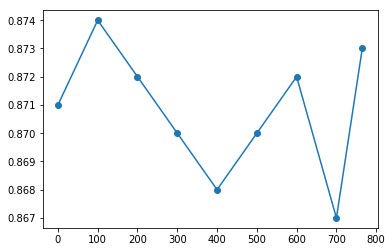

0.0005
Start of epoch:  117
Iteration 0, loss = 0.2213
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 100, loss = 0.2688
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.1793
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 300, loss = 0.3593
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 400, loss = 0.1945
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.3028
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Iteration 600, loss = 0.2471
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 700, loss = 0.2386
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Accuracy after epoch  117
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


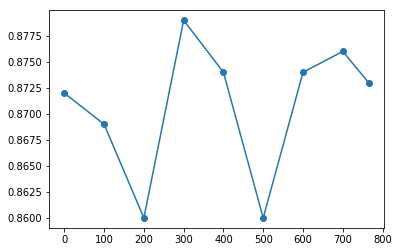

0.0005
Start of epoch:  118
Iteration 0, loss = 0.2937
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 100, loss = 0.1953
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 200, loss = 0.2296
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 300, loss = 0.2530
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.3349
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 500, loss = 0.1290
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 600, loss = 0.2793
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Iteration 700, loss = 0.2304
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Accuracy after epoch  118
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


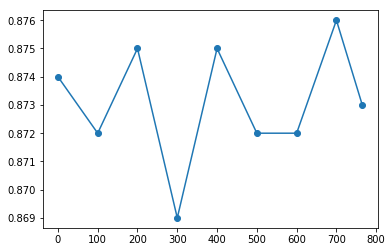

0.0005
Start of epoch:  119
Iteration 0, loss = 0.3119
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 100, loss = 0.1672
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 200, loss = 0.1743
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 300, loss = 0.3029
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.3588
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.2952
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)

Iteration 600, loss = 0.1828
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 700, loss = 0.2878
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Accuracy after epoch  119
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)


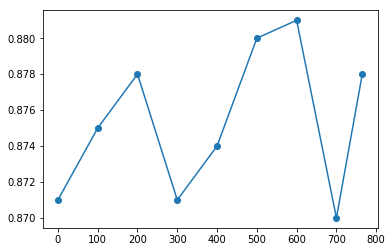

0.0005
Start of epoch:  120
Iteration 0, loss = 0.2790
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.1407
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.2217
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 300, loss = 0.2325
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 400, loss = 0.5016
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Iteration 500, loss = 0.3114
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Iteration 600, loss = 0.4180
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)

Iteration 700, loss = 0.3459
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Accuracy after epoch  120
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)


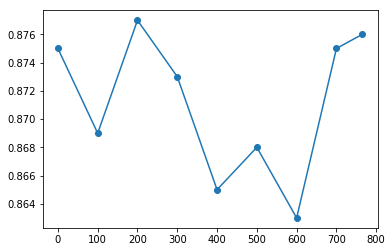

0.0005
Start of epoch:  121
Iteration 0, loss = 0.2357
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 100, loss = 0.3081
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 200, loss = 0.3717
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Iteration 300, loss = 0.2812
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 400, loss = 0.2902
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.1870
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 600, loss = 0.2576
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 700, loss = 0.2339
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Accuracy after epoch  121
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)


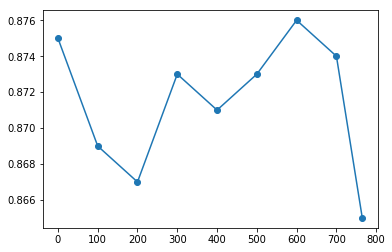

0.0005
Start of epoch:  122
Iteration 0, loss = 0.2149
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Iteration 100, loss = 0.2260
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)

Iteration 200, loss = 0.2699
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 300, loss = 0.1452
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 400, loss = 0.3541
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Iteration 500, loss = 0.3365
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 600, loss = 0.2390
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 700, loss = 0.3022
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Accuracy after epoch  122
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)


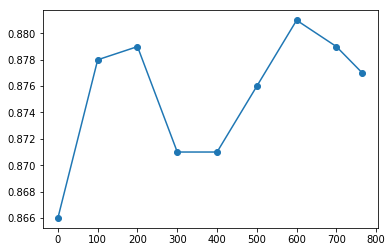

0.0005
Start of epoch:  123
Iteration 0, loss = 0.2071
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 100, loss = 0.2323
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 200, loss = 0.1837
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Iteration 300, loss = 0.1001
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Iteration 400, loss = 0.2630
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 500, loss = 0.4006
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 600, loss = 0.2693
Checking accuracy on validation set
Got 891 / 1000 correct (89.10)

Iteration 700, loss = 0.1972
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)

Accuracy after epoch  123
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)


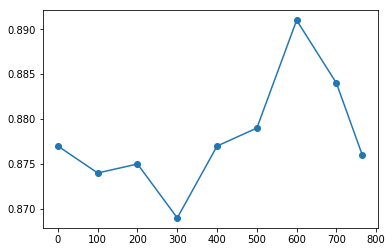

0.0005
Start of epoch:  124
Iteration 0, loss = 0.1847
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Iteration 100, loss = 0.1671
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 200, loss = 0.2433
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 300, loss = 0.4186
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)

Iteration 400, loss = 0.2678
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 500, loss = 0.2682
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 600, loss = 0.4224
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Iteration 700, loss = 0.2237
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Accuracy after epoch  124
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)


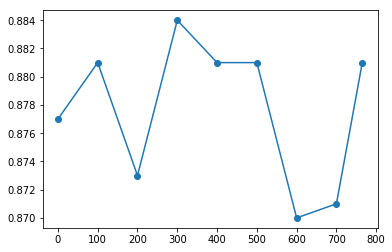

0.0005
Start of epoch:  125
Iteration 0, loss = 0.3781
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 100, loss = 0.2922
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)

Iteration 200, loss = 0.2710
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)

Iteration 300, loss = 0.2922
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 400, loss = 0.3165
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 500, loss = 0.2725
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Iteration 600, loss = 0.2500
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)

Iteration 700, loss = 0.2467
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Accuracy after epoch  125
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)


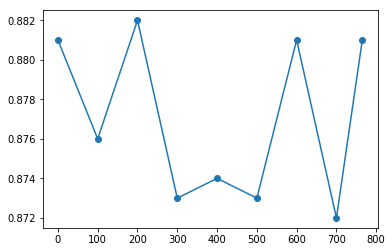

0.0005
Model saved at epoch:  70
Time taken =  7881.262847463229


In [27]:
model = None
optimizer = None

def CIFAR10_CNN():
    channel_1 = 32
    channel_2 = 32
    channel_3 = 64
    channel_4 = 64
    channel_5 = 128
    channel_6 = 128
    num_units_1 = 512
    num_units_2 = 256
    num_classes = 10
    bias = False
    dropout_prob = 0.4
    
    model = nn.Sequential(
            # Conv_1
                nn.Conv2d(3, channel_1, (5,5), padding=2, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_1),
            # Conv_2
                nn.Conv2d(channel_1, channel_2, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_2),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.Dropout2d(p=0.2),
            # Conv_3
                nn.Conv2d(channel_2, channel_3, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_3),
            # Conv_4
                nn.Conv2d(channel_3, channel_4, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_4),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.Dropout2d(p=0.3),
                #Flatten(),
            # Conv_5
                nn.Conv2d(channel_4, channel_5, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_5),
            # Conv_6
                nn.Conv2d(channel_5, channel_6, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_6),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.Dropout2d(p=dropout_prob),
            # Conv_7: Output layer
                nn.Conv2d(channel_6, 10, (4,4), padding=0, bias=True),
                Flatten())
    return model
'''# Linear_1
            nn.Linear(channel_4*8*8, num_units_1, bias=bias),
            nn.ReLU(),
            nn.BatchNorm1d(num_features= num_units_1),
            
        # Linear_2
            nn.Linear(num_units_1, num_units_2, bias=bias),
            nn.ReLU(),
            nn.BatchNorm1d(num_features= num_units_2),
            
        # Output layer
            nn.Linear(num_units_2, 10))'''

model = CIFAR10_CNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, dampening=0, weight_decay=1e-4, nesterov=False)

start_time = time.clock()
train_part34(model, optimizer, epochs=125)
end_time = time.clock()
print('Time taken = ', end_time - start_time)

In [36]:
print('Checking the final model state:')
_ = check_accuracy_part34(loader_test, model)
_ = check_accuracy_part34(loader_train, model)
print()
print('Checking the model that performed best on validation data:')
model.load_state_dict(torch.load('checkpoint_save_state_dict'))
_ = check_accuracy_part34(loader_test, model)

# Check training accuracy
_ = check_accuracy_part34(loader_train, model)

Checking the final model state:
Checking accuracy on test set
Got 8746 / 10000 correct (87.46)
Checking accuracy on validation set
Got 48087 / 49000 correct (98.14)

Checking the model that performed best on validation data:
Checking accuracy on test set
Got 8753 / 10000 correct (87.53)
Checking accuracy on validation set
Got 48067 / 49000 correct (98.10)


In [30]:
# Save model checkpoint to resume training later
torch.save({
    'epoch': 125,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'checkpoint_save')

|S. No.| Architecture | Epochs | test_acc | train_acc | Time  (s)|
|:----:| ------       | :----: | :----:   | :----:    |:-----:|
|1.    | 3 Conv layers <br> 2 linear layers <br> output layer | 15 | 80.28 | 99.66| - |
|2.    | 4 Conv layers <br> 2 linear layers <br> linear output layer| 15 | 81.29 | 99.96 | - |
|3.    | 4 Conv layers(more filters) <br> 2 linear layers <br> linear output layer | 20 | 84.65 | 100.00 | 5880|
|4.    | 4 Conv layers(even more filters) <br> 1 output Conv layer| 20 | 82.65 | 100.00 | 4244|
|5.    | 5 Conv layers (less filters per layer) <br> 1 output Conv layer| 20     | 84.58 | 99.99| 1762|
|6.    | Same as above <br> plus L2 weight decay, reg = 1e-3| 20     | 85.43 | 99.95| 1769|
|7.    | Same as above <br> plus L2 weight decay, reg = 1e-2 <br> reg=1e-1| 20     | 84.84 <br> 77.68| 95.53 <br> 80.36| 1770|
|8.    | 6 Conv layers <br> 1 output Conv layer <br> With L2, reg = 1e-3| 20     | 85.76 <br> 86.13| 99.99 <br> 99.99| 2823 <br> 2858|
|9.    | Same as 8. <br> plus dropout <br> reg=1e-4| 100 <br><br><br> 125<br>150| 86.88<br><br><br> 87.02 <br> 87.53| 97.63<br><br><br> 97.93 <br> 98.06| 6340<br><br><br> 7881 <br> -|

# Next:
dropout, more epochs and halve no. of filters in each layer
## With data aug, 15 epochs:
test_acc = 77.91, train_acc = 94.83

## Without data aug, 15 epochs:
test_acc = 77.02, train_acc = 99.98


### Lesson: Don't normalize the images -> seems to work better

# What I have learned:
* Deeper networks are generally better than wider networks.
    - They train much faster
    - Seem to overfit less in comparison to wider nets (on second thought, this might be due to not doing data augmentation with the wide net I used earlier but using it with the not-wide net.)
        - This might imply that wider nets are harder to train properly